In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn #neural network module
import torch.optim as optim #optimizer
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms

import time as time
from tqdm import tqdm

import pickle
import gc
import os

In [2]:
datasetpath=os.path.realpath('MonophonicDataset.pt')
PolDataset = os.path.realpath('PolyphonicDataset.pt')

Mono = False 

In [3]:
#Loading monophonic and polyphonic classes
class MonophonicDataset(Dataset):

   def __init__(self, Instruments):

      DS = torch.load(datasetpath)
      self.Data = []
      self.Instruments = Instruments

      for inst in Instruments:

        self.Data.extend(DS[inst])

      del DS
      gc.collect()


   def __len__(self):
      return len(self.Data)

   def __getitem__(self, idx):

      PreviousBars = self.Data[idx]['Bars'][0].to_dense()
      Bars = self.Data[idx]['Bars'][1].to_dense()

      prog = self.Data[idx]['Program']
      tempo = self.Data[idx]['Tempo'][0]

      TEMPO_MIN, TEMPO_MAX = 60, 200
      PROGRAM_MIN, PROGRAM_MAX = 1, 128

      tempo_norm = (tempo - TEMPO_MIN) / (TEMPO_MAX - TEMPO_MIN)
      prog_norm = (prog - PROGRAM_MIN) / (PROGRAM_MAX - PROGRAM_MIN)


      Cond1D = torch.tensor([tempo_norm] + [prog_norm], dtype=torch.float, device=Bars.device)
      return Bars, PreviousBars, Cond1D




class PolyphonicDataset(Dataset):

   def __init__(self):

         DS = torch.load(PolDataset, weights_only=False)
         self.Data = []

         self.Data.extend(DS)

         del DS
         gc.collect()

   def __len__(self):
      return len(self.Data)

   def __getitem__(self, idx):

      PreviousBars = self.Data[idx]['Bars'][0].to_dense()
      Bars = self.Data[idx]['Bars'][1].to_dense()

      prog = self.Data[idx]['Program']
      tempo = self.Data[idx]['Tempo']
      genre = self.Data[idx]['Genre']


      TEMPO_MIN, TEMPO_MAX = 60, 200
      PROGRAM_MIN, PROGRAM_MAX = 1, 130
      GENRE_MIN, GENRE_MAX = 0, 9

      tempo_norm = (tempo - TEMPO_MIN) / (TEMPO_MAX - TEMPO_MIN)
      genre_norm = (genre - GENRE_MIN) / (GENRE_MAX - GENRE_MIN)
      prog_norm = [(p - PROGRAM_MIN) / (PROGRAM_MAX - PROGRAM_MIN) for p in prog]


      Cond1D = torch.tensor([tempo_norm, genre_norm] + prog_norm, dtype=torch.float, device=Bars.device)
      return Bars, PreviousBars, Cond1D

In [4]:
EPOCHS = 20
noise_dim = 100
BATCH_SIZE = 72

if Mono: Data = MonophonicDataset(Instruments=['Piano'])
else: Data = PolyphonicDataset()

def getDataloader(dataset, batch_size, num_batches):
    # Total samples to use per epoch
    subset_size = batch_size * num_batches
    indices = np.random.choice(len(dataset), size=subset_size, replace=False)
    sampler = SubsetRandomSampler(indices)
    return DataLoader(dataset, batch_size=batch_size, sampler=sampler, drop_last=True)

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU available')

elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print('mps available')
else:
    device = torch.device("cpu")
    print('GPU not available')

mps available


### Concatenation

Definition of the concatenation functions that are used in the hidden layers to concatenate the output and the 1_d and 2_d conditions.

1_d conditioning vector of shape $[n,1]$ with an output of shape $[batch,features,a,b]$:
* first we have to duplicate the vector $a\cdot b$ times to get a tensor of shape $[batch,n,a,b]$
* then we can concatenate the two tensors in the depth dimension (i.e dim=1)

2_d conditioning matrix of the same shape of the output $[batch,features,a,b]$ except the depth dim (it must be that because how we build the conditioner CNN):
* first we check that the dimensions are correct
* we concatenate the two tensors in the depth dimension (i.e dim=1)

In [6]:
def conv_cond_concat(x, y):
    """Concatenate conditioning vector on feature map axis."""
    x_shapes = x.shape  #[batch,n_features,a,b]
    y_shapes = y.shape  #[batch,n]
    y2 = y.view(x_shapes[0],y_shapes[1],1,1)                              #[batch,n,1,1]
    y2 = y2.expand(x_shapes[0],y_shapes[1],x_shapes[2],x_shapes[3])      #[batch,n,a,b]

    return torch.cat((x, y2),dim=1)                                     #[batch,n_features+n,a,b]

def conv_prev_concat(x, y):
    """Concatenate conditioning vector on feature map axis."""
    x_shapes = x.shape  #[batch,n_features,a,b]
    y_shapes = y.shape  #[batch,16,a,b]
    if x_shapes[2:] == y_shapes[2:]:
        y2 = y.expand(x_shapes[0],y_shapes[1],x_shapes[2],x_shapes[3])  #[batch,16,a,b]

        return torch.cat((x, y2),dim=1)                                 #[batch,n_features+16,a,b]

    else:
        print(x_shapes[2:])
        print(y_shapes[2:])

### The Generator and the Conditioner

The generator uses `ConvTranspose2d` (upsampling) layers to produce an image from a seed (random noise). Start with two `Dense` layers that take this seed as input and transform it to a tensor of shape $[batch size,128,1,2]$, then upsample several times until we reach the desired size of a bar of $[instrument,128,16]$. We use  the `ReLU` activation for each layer, except the output layer which can use `Sigmoid` to predict pixel values in the [0, 1] range.

Coupled to the generator there is the conditioner that uses `Conv2d` (sampling) layers to produce the 2_d tensors that serve as informations from the preaviou bar. The conditioner can be viewed as the reverse of the generator because it uses filters with the same shapes of the ones in the generator. In this case we use  the `LeakyReLU` activation for each layer.

In [7]:
class Generator(nn.Module):

    def __init__(self, input_size, cond_1d_size, instrument_size=1, n_hlayers=128):
            super().__init__()

            self.input_size = input_size
            self.instrument_size = instrument_size
            self.cond1d_dim = cond_1d_size

            #generator layers
            #as said in the DCGAN paper always ReLU activation function in the generator excluded the last layer
            #as said in the DCGAN paper always batchnorm iin the generator excluded the last layer
            self.ff1 = nn.Sequential(
                nn.Linear(input_size+cond_1d_size, 1024),                                                               #[batch,1024]
                nn.BatchNorm1d(1024),
                nn.ReLU()
                )
            self.ff2 = nn.Sequential(
                nn.Linear(1024+cond_1d_size,n_hlayers*2),                                                                                    #[batch,512]
                nn.BatchNorm1d(n_hlayers*2),
                nn.ReLU()
                )
            #reshape to [batch size,128,1,2]
            # #+condition [batch,128+cond_1d_size+16,1,2]
            self.cnn1 = nn.Sequential(
                nn.ConvTranspose2d(n_hlayers+cond_1d_size+16, n_hlayers, kernel_size=(1,2), stride=(2,2), bias=False, padding=0),           #[batch,128,1,4]
                nn.BatchNorm2d(n_hlayers),
                nn.ReLU()
                )
            #+condition [batch,128+cond_1d_size+16,1,2]
            self.cnn2 = nn.Sequential(
                nn.ConvTranspose2d(n_hlayers+cond_1d_size+16, n_hlayers, kernel_size=(1,2), stride=(2,2), bias=False, padding=0),           #[batch,128,1,8]
                nn.BatchNorm2d(n_hlayers),
                nn.ReLU()
                )
            #+condition [batch,128+cond_1d_size+16,1,2]
            self.cnn3 = nn.Sequential(
                nn.ConvTranspose2d(n_hlayers+cond_1d_size+16, n_hlayers, kernel_size=(1,2), stride=(2,2), bias=False, padding=0),           #[batch,128,1,16]
                nn.BatchNorm2d(n_hlayers),
                nn.ReLU()
                )
            #+condition [batch,128+cond_1d_size+16,1,2]
            self.cnn4 = nn.Sequential(
                nn.ConvTranspose2d(n_hlayers+cond_1d_size+16, instrument_size, kernel_size=(128,1), stride=(2,1), bias=False, padding=0),       #[batch,instrument_size,128,16]
                nn.Sigmoid()
                #Sigmoid funciotn because we want to generate the matrixes of music without velocity, i.e. only (0,1)
                #Thus we use the sigmoid which is a smoother version of the sign function
                )
            #conditioner layers
            # #as in Midinet model we use the Leaky activation funciton for the conditioner
            self.h0_prev = nn.Sequential(
                nn.Conv2d(in_channels=instrument_size, out_channels=16, kernel_size=(128,1), stride=(2,1)),                  #[batch,16,1,16]
                nn.BatchNorm2d(16),
                nn.LeakyReLU()          #note: in the original paper leak=0.2, default leak=0.01
                )
            self.h1_prev = nn.Sequential(
                nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1,2), stride=(2,2)),                                  #[batch,16,1,8]
                nn.BatchNorm2d(16),
                nn.LeakyReLU()
                )
            self.h2_prev = nn.Sequential(
                nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1,2), stride=(2,2)),                                  #[batch,16,1,4]
                nn.BatchNorm2d(16),
                nn.LeakyReLU()
                )
            self.h3_prev = nn.Sequential(
                nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1,2), stride=(2,2)),                                  #[batch,16,1,2]
                nn.BatchNorm2d(16),
                nn.LeakyReLU()
                )

    def forward(self, z, prev_bar, cond_1d, batch_size):

            #2d condiiton
            cond0 = self.h0_prev(prev_bar)          #[batch,16,1,16]
            cond1 = self.h1_prev(cond0)             #[batch,16,1,8]
            cond2 = self.h2_prev(cond1)             #[batch,16,1,4]
            cond3 = self.h3_prev(cond2)             #[batch,16,1,2]

            #single cond_1d size =[n,1], batch_cond_1d size = [batch_size,n]

            input = torch.cat((z,cond_1d), dim=1)   #[batch_size, input_size+cond_1d_size]

            h0 = self.ff1(input)                    #[batch,1024]
            h0 = torch.cat((h0,cond_1d), dim=1)     #[batch,1024+cond_1d_size]

            h1 = self.ff2(h0)                       #[batch,256]
            h1 = h1.reshape(batch_size, 128, 1, 2)  #[batch,128,1,2]
            h1 = conv_cond_concat(h1,cond_1d)       #[batch,128+cond_1d_size,1,2]
            h1 = conv_prev_concat(h1,cond3)         #[batch,128+cond_1d_size+16,1,2]

            h2 = self.cnn1(h1)                      #[batch,128,1,4]
            h2 = conv_cond_concat(h2,cond_1d)       #[batch,128+cond_1d_size,1,4]
            h2 = conv_prev_concat(h2,cond2)         #[batch,128+cond_1d_size+16,1,4]

            h3 = self.cnn2(h2)                      #[batch,128,1,8]
            h3 = conv_cond_concat(h3,cond_1d)       #[batch,128+cond_1d_size,1,8]
            h3 = conv_prev_concat(h3,cond1)         #[batch,128+cond_1d_size+16,1,8]

            h4 = self.cnn3(h3)                      #[batch,128,1,16]
            h4 = conv_cond_concat(h4,cond_1d)       #[batch,128+cond_1d_size,1,16]
            h4 = conv_prev_concat(h4,cond0)         #[batch,128+cond_1d_size+16,1,16]

            out = self.cnn4(h4)             #[batch,instrument_size,128,16]

            return out

### The Discriminator

The discriminator uses `Conv2d` (sampling) layers to produce a scalar output from a bar input. Start with two `Conv2d` layers that reduce the size of the input, then use two `Dense` layers. We use  the `LeakyReLU` activation for each layer, except the output layer which can use `Sigmoid` to predict true-false probability value in the [0, 1] range. Note that the activation is included in the loss function.

In [8]:
class MinibatchDiscrimination(nn.Module):
    def __init__(self, in_features, out_features, kernel_dim):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.kernel_dim = kernel_dim
        self.T = nn.Parameter(torch.randn(in_features, out_features, kernel_dim))

    def forward(self, x):
        # x is batch_sizexA
        # T is AxBxC
        matrices = x @ self.T.view(self.in_features, -1)                # matrix moltiplication, result shape: [batch_size, B*C]
        matrices = matrices.view(-1, self.out_features, self.kernel_dim)    #M shape [batch, B, C]

        # compute L1 distances between samples
        M = matrices.unsqueeze(0)  # [1,batch,B,C]
        M_T = M.permute(1, 0, 2, 3)  # [batch,1,B,C]
        norm = torch.abs(M - M_T).sum(3)  # first broadcast [batch,batch,B,C], then [batch,batch,B]
        cbij = torch.exp(-norm)
        o_b = cbij.sum(0)   # [batch,B], if j !=0 i in teh sum then subtract self distance (cbij.sum(0) - 1)

        x = torch.cat([x, o_b], 1)
        return x

In [9]:
class Discriminator(nn.Module):

    def __init__(self, cond_1d_size, instrument_size=1, mini_size=100):
        super().__init__()

        self.instrument_size = instrument_size
        self.cond1d_dim = cond_1d_size

        #as said in the DCGAN paper always batchnorm in the discriminator layers excluded the first layer
        self.cnn1 = nn.Sequential(
            nn.Conv2d(2*instrument_size+cond_1d_size, 32, kernel_size=(128,2), stride=(2,2), padding=0),        #[batch,32,1,8]
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1)
        )
        #+condition [batch,14+cond_1d_size,1,8]
        self.cnn2 = nn.Sequential(
            nn.Conv2d(32+cond_1d_size, 77, kernel_size=(1,4), stride=2, padding=0),                             #[batch,77,1,3]
            #Adding residual block
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1)
        )

        self.ffnn1 = nn.Sequential(
             #+condition [batch,231+cond_1d_size]
            nn.Linear(231+cond_1d_size, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2)
        )

        self.minibatch = MinibatchDiscrimination(in_features=1024, out_features=mini_size,kernel_dim=3)

        #+condition [batch,1024+mini_size+cond_1d_size]
        self.ffnn2 = nn.Linear(1024+cond_1d_size+mini_size, 1)      #no sigmoid activation function because it is already in the definition of the cross entropy loss function


    def forward(self, x, prev_bar, cond_1d):
        input = conv_cond_concat(x,cond_1d)         #[batch,instrument_size+cond_1d_size,128,16]
        input = conv_prev_concat(input,prev_bar)    #[batch,2*instrument_size+cond_1d_size,128,16]

        h0 = self.cnn1(input)                       #[batch,14,1,8]
        fm = h0
        h0 = conv_cond_concat(h0, cond_1d)          #[batch,14+cond_1d_size,1,8]

        h1 = self.cnn2(h0)                          #[batch,77,1,3]
        h1 = torch.flatten(h1, 1)                   #[batch,77*3*1]
        h1 = torch.cat((h1,cond_1d),dim=1)          #[batch,231+cond_1d_size]

        h2 = self.ffnn1(h1)                         #[batch,1024]
        h2 = self.minibatch(h2)                     #[batch,1024+mini_size]
        h2 = torch.cat((h2,cond_1d),dim=1)          #[batch,1024+mini_size+cond_1d_size]

        h3 = self.ffnn2(h2)                         #[batch,1]
        h3_sigmoid = torch.sigmoid(h3)


        return h3_sigmoid, h3, fm



### Weights initialization

Is this ok?

In [10]:
# def weights_init(m):
#     classname = m.__class__.__name__
#     if classname.find('Conv') != -1:
#         nn.init.xavier_uniform_(m.weight.data)*0
#     if classname.find('Linear') != -1:
#         nn.init.xavier_uniform_(m.weight.data)*0
#     elif classname.find('BatchNorm') != -1:
#         nn.init.normal_(m.weight.data, 1.0, 0.2)*0
#         nn.init.constant_(m.bias.data, 0)*0


def weights_init(m):
    if isinstance(m, (nn.ConvTranspose2d, nn.Conv2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)  # DCGAN standard
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


### Creation of the model

In [11]:
if Mono:
  generator = Generator(input_size=100, cond_1d_size=2, instrument_size=1, n_hlayers=128)
else:
  generator = Generator(input_size=100, cond_1d_size=6, instrument_size=4, n_hlayers=128)
generator.apply(weights_init)

Generator(
  (ff1): Sequential(
    (0): Linear(in_features=106, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (ff2): Sequential(
    (0): Linear(in_features=1030, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (cnn1): Sequential(
    (0): ConvTranspose2d(150, 128, kernel_size=(1, 2), stride=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (cnn2): Sequential(
    (0): ConvTranspose2d(150, 128, kernel_size=(1, 2), stride=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (cnn3): Sequential(
    (0): ConvTranspose2d(150, 128, kernel_size=(1, 2), stride=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, trac

In [12]:
if Mono:
  discriminator = Discriminator(cond_1d_size=2, instrument_size=1)
else:
  discriminator = Discriminator(cond_1d_size=6, instrument_size=4)
discriminator.apply(weights_init)

Discriminator(
  (cnn1): Sequential(
    (0): Conv2d(14, 32, kernel_size=(128, 2), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.1, inplace=False)
  )
  (cnn2): Sequential(
    (0): Conv2d(38, 77, kernel_size=(1, 4), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.1, inplace=False)
  )
  (ffnn1): Sequential(
    (0): Linear(in_features=237, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.2, inplace=False)
  )
  (minibatch): MinibatchDiscrimination()
  (ffnn2): Linear(in_features=1130, out_features=1, bias=True)
)

### Dimension testing

Produce a noise vector of size `[10, 100]`, a noise 1d condition vector of size `[10, 15]`, and a noise 2d condition tensor of size `[10, 1, 128,16]`. Note that we need a 1d and a 2d contions for each batch input. Then we use the (as yet **untrained**) generator to create an image of expected output shape $[10,1,128,16]$.

Then use the (yet **untrained**) discriminator to classify the generated images as real or fake. The model will be trained to output the probability that the image is real in the first output component, thus we expect an output vector of size `[10, 1]` with $x_i \in [0,1]$.

In [13]:
############################ input (batch_size=10, vector_size=100) ###############################
noise = torch.normal(0, 1, [10, 100])
print(noise.shape)
############################ conditions ###############################
if Mono:
  cond_1d = torch.normal(0,1,[10,2])
  prev_bar = torch.normal(0, 1, [10, 1, 128, 16])
else:
  cond_1d = torch.normal(0,1,[10,6])
  prev_bar = torch.normal(0, 1, [10, 4, 128, 16])


############################ generator ###############################
generated_bar = generator(noise, prev_bar, cond_1d, batch_size=10).detach()
print(generated_bar.shape)
############################ discriminator ###############################
decision, __, __= discriminator(generated_bar, prev_bar, cond_1d)
print(decision)

torch.Size([10, 100])
torch.Size([10, 4, 128, 16])
tensor([[0.4905],
        [0.6058],
        [0.3550],
        [0.4535],
        [0.5067],
        [0.4524],
        [0.5819],
        [0.6817],
        [0.4992],
        [0.5251]], grad_fn=<SigmoidBackward0>)


In [14]:
generated_bar[0][0]

tensor([[0.5026, 0.5145, 0.5190,  ..., 0.5288, 0.4561, 0.4576],
        [0.5000, 0.5354, 0.4568,  ..., 0.4988, 0.5029, 0.5335],
        [0.5053, 0.5547, 0.5676,  ..., 0.5604, 0.5923, 0.5419],
        ...,
        [0.5377, 0.5375, 0.5235,  ..., 0.5244, 0.5193, 0.5213],
        [0.5345, 0.4578, 0.5122,  ..., 0.4564, 0.4872, 0.4877],
        [0.5452, 0.4873, 0.4642,  ..., 0.5105, 0.4799, 0.5179]])

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.
The discriminator loss is of the form:

$\frac{1}{m}\sum_{i=1}^{m}-[\log D(\boldsymbol{x}^{(i)}) +\log(1-D(G(\boldsymbol{z}^{(i)})))]$

We inplement one-sided label smoothing to penalize self confidence and imporve the convergence of the training. Thus we substitute the discriminator's predictions on real images to an array of 1s with an array of (1-$\alpha$)s and the loss function becomes:

$\frac{1}{m}\sum_{i=1}^{m}-[(1-\alpha) \log D(\boldsymbol{x}^{(i)}) +\alpha \log (1-D(\boldsymbol{x}^{(i)}))+\log(1-D(G(\boldsymbol{z}^{(i)})))]$

In [15]:
cross_entropy = nn.BCEWithLogitsLoss()
MSE=nn.MSELoss()

In [16]:
def discriminator_loss(real_output, fake_output, device, alpha=0.1):

    #real_targets = torch.ones_like(real_output, device=device)                 #no label smoothing -> True output expected output is 1
    real_targets = torch.full_like(real_output, 1.0 - alpha, device=device)     #one side label smoothing to penalize self confidence
    fake_targets = torch.zeros_like(fake_output, device=device)                 #no label smoothing -> Fake output expected output is 0

    real_loss = cross_entropy(real_output, real_targets)
    fake_loss = cross_entropy(fake_output, fake_targets)

    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1).
The generator loss is of the form:

$\frac{1}{m}\sum_{i=1}^{m}\log(1-D(G(\boldsymbol{z}^{(i)})))$

However this loss has some convergence issues due to vanishing gradients. So instead we use the following loss which has the same trend but stronger gradient when the discriminator is too good at recognizing fake samples.

$\frac{1}{m}\sum_{i=1}^{m}-\log(D(G(\boldsymbol{z}^{(i)})))$

Which is the Binary crossentropy between $D(G(\boldsymbol{z}^{(i)}))$ and the probability distribution that has $y^{(i)} = 1 \forall i$, i.e. we are forcing the generator to produce samples that will make the discriminator predict that fake samples are real.

Moreover we add a regularizer term so-called feature matching such that the distributions of the real and generated data are enforced to be close.

$\lambda_1 ||E_{x \sim p(x)} [x] - E_{z\sim p(z)} [G(z)] ||^2 + \lambda_2 ||E_{x \sim p(x)} [f(x)] - E_{z \sim p(z)} [f(G(z))] ||^2$


In [17]:
def generator_loss(fake_output, real_bar, fake_bar, real_f, fake_f, device, lambda1=0.1, lambda2=0.01):

    gen_loss = cross_entropy(fake_output, torch.ones_like(fake_output, device=device))

    mean_real = torch.mean(real_bar, dim=0)
    mean_fake = torch.mean(fake_bar, dim=0)
    l2_data = MSE(mean_real, mean_fake)

    mean_real_feat = torch.mean(real_f, dim=0)
    mean_fake_feat = torch.mean(fake_f, dim=0)
    l2_feat = MSE(mean_real_feat, mean_fake_feat)

    return gen_loss+lambda1*l2_data+lambda2*l2_feat

### Optimizers

With DCGAN the training is very diffuclt so we decide to use Adam optimizer as suggested by the paper. Note that with Adam we use both momentum and RMSprop to normalized velocities. Discriminator and generator need two different optimizers (conditioner is included in the generator training).

In [18]:
generator.to(device)
discriminator.to(device)

gen_opt = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
dis_opt = optim.Adam(discriminator.parameters(), lr=4e-4, betas=(0.5, 0.999))

### Training loop

In [19]:
def LossPenalty(GenBars, ActualLoss):

   mean = GenBars.mean().item()
   BinaryBar = (GenBars > mean).float().squeeze(0).squeeze(0).cpu().numpy()

   ActiveNotes = np.sum(BinaryBar, axis = 0)

   Notes = (ActiveNotes > 5)
   Sums = np.sum(Notes)

   #PenaltyTerm on the loss if more that 5 notes are active at the same time
   PenaltyTerm = ActualLoss + 0.05*ActualLoss*Sums

   return PenaltyTerm

In [20]:
def train_step(bars, cond_1d, prev_bar, generator, discriminator, batch_size,
               noise_dim, device, dis_opt, gen_opt):
    # --- Ensure all tensors are on the correct device ---
    bars = bars.to(device)
    cond_1d = cond_1d.to(device)
    prev_bar = prev_bar.to(device)

    # --- Discriminator training ---
    noise = torch.randn([batch_size, noise_dim], device=device)

    bars_noise = bars + torch.randn_like(bars) * 0.1
    bars_noise = torch.clamp(bars_noise, 0, 1)

    # Generate fake samples
    generated_bars = generator(noise, prev_bar, cond_1d, batch_size)

    # Forward pass (real + fake)
    real_output, real_D, _ = discriminator(bars_noise, prev_bar, cond_1d)
    fake_output, fake_D, _ = discriminator(generated_bars.detach(), prev_bar, cond_1d)

    # Discriminator loss
    disc_loss = discriminator_loss(real_D, fake_D, device)
    discriminator.zero_grad()
    disc_loss.backward()
    dis_opt.step()

    # --- Generator training (2 steps) ---
    gen_losses = []
    for _ in range(1):  # Consistent 2:1 update ratio
        noise = torch.randn([batch_size, noise_dim], device=device)
        generated_bars = generator(noise, prev_bar, cond_1d, batch_size)
        _, fake_D, fake_fm = discriminator(generated_bars, prev_bar, cond_1d)

        with torch.no_grad():
            _, real_D, real_fm = discriminator(bars_noise, prev_bar, cond_1d)

        gen_loss = generator_loss(fake_D, bars, generated_bars, real_fm, fake_fm, device)

        generator.zero_grad()
        gen_loss.backward()
        gen_opt.step()
        gen_losses.append(gen_loss.item())

    return sum(gen_losses) / len(gen_losses), disc_loss.item()

supponendo che nel dataloader ogni dato sia una bar + la preavious bar + 1d condition sugli strumenti utilizzati

In [21]:
# gloss = []
# dloss = []

# for epoch in range(EPOCHS):

#     start = time.time()
#     generator.train()
#     discriminator.train()
#     gen_losses = []
#     disc_losses = []
#     print('#################')
#     print(f"Epoch: {epoch+1}")

#     iterator = tqdm(dataloader)
#     for bar_batch, prev_bar_batch, instrument_batch in iterator:
#         bar_batch = bar_batch.to(dtype=torch.float32, device=device)
#         prev_bar_batch = prev_bar_batch.to(dtype=torch.float32, device=device)
#         instrument_batch = instrument_batch.to(dtype=torch.float32, device=device)
#         #instrument_batch = torch.zeros_like(cond_1d)

#         if Mono:
#             bar_batch = bar_batch.unsqueeze(1)
#             prev_bar_batch=prev_bar_batch.unsqueeze(1)

#         gen_loss, disc_loss = train_step(bar_batch, instrument_batch, prev_bar_batch, generator, discriminator,
#                                          BATCH_SIZE, noise_dim, device, dis_opt, gen_opt)
#         gen_losses.append(gen_loss)
#         disc_losses.append(disc_loss)

#         iterator.set_description('Discriminator loss: {}, Generator loss: {}'.format(disc_loss, gen_loss))

#     gloss.append(np.mean(gen_losses))
#     dloss.append(np.mean(disc_losses))
#     #print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
#     print(f'dLoss: {dloss[-1]}, gLoss: {gloss[-1]}')


### Weights and loss analysis

First let's plot the 2 losses over the epochs, if it works correctly the generator loss would have to decrease and the discriminator one would have to increase

In [22]:
# plt.plot(gloss, label='Generator loss')
# plt.plot(dloss, label='Discriminator loss')
# plt.legend()
# plt.show()

In [23]:
from Preprocessing import *
from PolyphonicPreprocessing import *

Mono = False

TEMPO_MIN, TEMPO_MAX = 60, 200  # Typical tempo range
PROGRAM_MIN, PROGRAM_MAX = 1, 130  # MIDI program range
GENRE_MIN, GENRE_MAX = 0, 9

def NormCond(tempo, programs, genre, Mono):

   tempo_norm = (tempo - TEMPO_MIN) / (TEMPO_MAX - TEMPO_MIN)
    
   if Mono:
      programs_norm = (programs - PROGRAM_MIN) / (PROGRAM_MAX - PROGRAM_MIN)
      return [tempo_norm] + [programs_norm]
   else:
      programs_norm = [(p - PROGRAM_MIN) / (PROGRAM_MAX - PROGRAM_MIN) for p in programs]
      genre_norm = (genre - GENRE_MIN) / (GENRE_MAX - GENRE_MIN)
      return [tempo_norm, genre_norm] + programs_norm
    
   
if Mono:
   Dataset = torch.load('MonophonicDataset.pt')
   
else:
   Dataset = PolyphonicPreProcessing(nDir = 1000)

Preprocessing: 100%|██████████| 1000/1000 [04:33<00:00,  3.65it/s]


1911


In [24]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU available')
else:
    device = torch.device("cpu")
    print('GPU not available')


def LoadModel(Cond1D_Size, instrumentSize, Which):

    Path = os.path.realpath('ModelParameters')

    files = [
        ['MonoGenParam.torch'],
        ['PolyGenParam.torch']
    ]

    generator = Generator(input_size=100, cond_1d_size=Cond1D_Size, instrument_size=instrumentSize, n_hlayers=128)
    generator.apply(weights_init)
    generator.to(device)
    # Load the state dict previously saved
    generator_state_dict = torch.load(os.path.join(Path, files[Which][0]), map_location=torch.device('cpu'))
    # Update the network parameters
    generator.load_state_dict(generator_state_dict)

    return generator

                                                    #MOnophonic or polyphonic
if Mono: generator = LoadModel(Cond1D_Size=2, instrumentSize=1, Which=0)
else: generator = LoadModel(Cond1D_Size=6, instrumentSize=4, Which=1)

GPU not available


In [25]:
def GenerateBars(generator, bar, nBars = 8):
   device = torch.device('cpu')

   generator.eval().to(device)

   if Mono:
      Instrument = 'Piano'
      prev_bar = Dataset[Instrument][bar]['Bars'][0].to_dense().float().to(device)
      prev_bar = prev_bar.unsqueeze(0).unsqueeze(0) 
      InstrumentCode = Dataset[Instrument][bar]['Program']
      Tempo = Dataset[Instrument][bar]['Tempo'][0]
      Cond1D_Norm = torch.tensor([NormCond(Tempo, InstrumentCode, None, Mono)], dtype= torch.float32, device = device)


   else:
      prev_bar = Dataset[bar]['Bars'][0].to_dense().float().to(device)
      prev_bar = prev_bar.unsqueeze(0)
      InstrumentCode = Dataset[bar]['Program']
      Tempo = Dataset[bar]['Tempo']
      Genre = Dataset[bar]['Genre']
      Cond1D = [Tempo, Genre] + InstrumentCode
      Cond1D_Norm = torch.tensor([NormCond(Cond1D[0], Cond1D[2:], Cond1D[1], Mono)], dtype= torch.float32, device = device)


   Bars = []
   Bars.append(prev_bar.squeeze(0).cpu().numpy())
      
   for i in range(nBars):
      noise = torch.rand([1, 100], device=device)

      #print(np.mean(np.array(noise)))

      with torch.no_grad():
         generated_bar = generator(noise, prev_bar, Cond1D_Norm, 1)

      mean = generated_bar.mean().item()
      binary_bar = (generated_bar > 0.11).float()
      if Mono: 
         Bars.append(binary_bar.squeeze(0).squeeze(0).cpu().numpy()) 
         prev_bar = Dataset[Instrument][bar + i + 1]['Bars'][0].unsqueeze(0).unsqueeze(0).to_dense().float().to(device)
         #prev_bar = binary_bar.detach()
      else: 
         Bars.append(binary_bar.squeeze(0).cpu().numpy()) 
         #prev_bar = Dataset[bar + i + 1]['Bars'][0].unsqueeze(0).to_dense().float().to(device)
         prev_bar = binary_bar.detach()
      #print(mean, generated_bar.std().item())

   return Bars, InstrumentCode


bar = np.random.randint(len(Dataset))
Bars, InstrumentCode = GenerateBars(generator, bar)


# if Mono:
#    ConcBars = np.concatenate(Bars, axis = 1)
#    MonoBarsToMIDI(ConcBars, Instrument=InstrumentCode, title='GeneratedAudio/Monotest')

# else:
#    PolyConcBars = np.concatenate(Bars, axis = 2)

#    PolyBarsToMIDI(PolyConcBars, Cond1D=Cond1D, title='GeneratedAudio/Polytest1')


In [27]:
Real, Fake = [], []
for i in range(1000):
   nBars = 30
   bar = np.random.randint(len(Dataset)- nBars) 
   Bars, InstrumentCode = GenerateBars(generator, bar, nBars = nBars)

   Real.extend(np.array([Dataset[i + bar]['Bars'][0].to_dense() for i in range(nBars+1)]))
   Fake.extend(Bars)

In [28]:
def NoteDensity(midi_tensor):
   if np.shape(midi_tensor)[0] == 4:  
      density_per_instrument = np.mean(np.sum(midi_tensor, axis=2), axis=1)
      total_density = np.mean(np.sum(midi_tensor, axis=(0,2)))
      return density_per_instrument, total_density
   else:  # monophonic
      total_density = np.mean(np.sum(midi_tensor, axis=1))
      return None, total_density
   


def PitchRange(midi_tensor):
   active_pitches = np.where(np.sum(midi_tensor, axis=-1) > 0)
   if len(active_pitches[0]) > 0:
      min_pitch = np.min(active_pitches[-1])  
      max_pitch = np.max(active_pitches[-1])
      pitch_range = max_pitch - min_pitch
   else:
      min_pitch = max_pitch = pitch_range = 0
   return min_pitch, max_pitch, pitch_range

In [29]:
def CompareDistributions(generated_samples, real_samples):
   # Compare simple statistics
   gen_densities = [NoteDensity(s)[1] for s in generated_samples]
   real_densities = [NoteDensity(r)[1] for r in real_samples]
   
   plt.figure(figsize=(5, 4))
   plt.hist(gen_densities, alpha=0.6, label='Generated bars', bins=50, zorder = 100, density=True, color='#2ca02c')
   plt.hist(real_densities, alpha=0.6, label='Real bars', bins=50, zorder = 100, density=True, color='#d62728')
   plt.xlabel('Note Density')
   plt.ylabel('Density')
   plt.grid(alpha = 0.4)
   plt.legend()
   plt.tight_layout()
   #plt.savefig('Images/NoteDensity.pdf')
   
   gen_ranges = [PitchRange(s)[2] for s in generated_samples]
   real_ranges = [PitchRange(s)[2] for s in real_samples]
   
   plt.figure(figsize=(5, 4))
   plt.hist(gen_ranges, alpha=0.6, label='Generated bars', bins=50, zorder = 100, density=True, color='#6a0dad')
   plt.hist(real_ranges, alpha=0.8, label='Real bars', bins=50, zorder = 100, density=True , color='#ffb347')
   plt.xlabel('Pitch Range')
   plt.ylabel('Density')
   plt.grid(alpha = 0.4)
   plt.legend()
   plt.tight_layout()
   #plt.savefig('Images/PitchDensity.pdf')

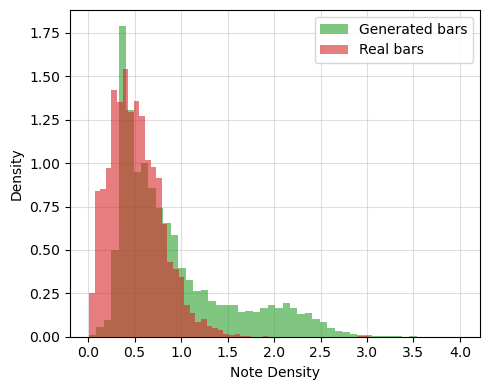

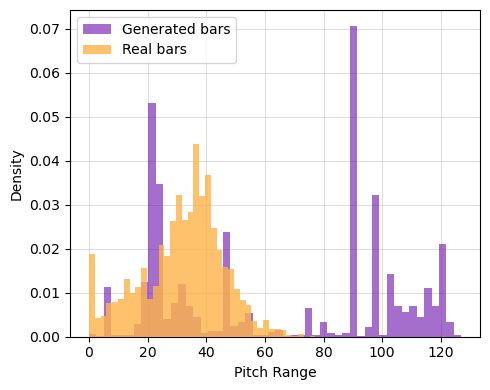

In [30]:
CompareDistributions(Fake, Real)

In [ ]:
import hashlib
from collections import Counter

def BarToString(midi_tensor):
    """
    Convert a MIDI bar tensor to a string representation for hashing
    This allows us to count identical bars
    """
    # Flatten the tensor and convert to string
    if len(midi_tensor.shape) == 3:  # polyphonic (4, 128, 16)
        flat = midi_tensor.flatten()
    else:  # monophonic (128, 16)
        flat = midi_tensor.flatten()
    
    # Convert to string (you could also use hash for memory efficiency)
    return ''.join(map(str, flat.astype(int)))

def BarToHash(midi_tensor):
    """
    Convert bar to hash for memory-efficient comparison
    """
    bar_string = BarToString(midi_tensor)
    return hashlib.md5(bar_string.encode()).hexdigest()

def CalculateBarEntropy(generated_samples):
    """
    Calculate Shannon entropy based on unique bar patterns
    
    Args:
        generated_samples: list of MIDI tensors
    
    Returns:
        entropy: Shannon entropy value
        unique_bars: number of unique bars
        total_bars: total number of bars
        repetition_ratio: fraction of bars that are repeats
    """
    # Convert each bar to a hash for efficient comparison
    bar_hashes = [BarToHash(sample) for sample in generated_samples]
    
    # Count occurrences of each unique bar
    bar_counts = Counter(bar_hashes)
    
    # Calculate probabilities
    total_bars = len(generated_samples)
    unique_bars = len(bar_counts)
    
    probabilities = np.array(list(bar_counts.values())) / total_bars
    
    # Calculate Shannon entropy
    entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))
    
    # Calculate repetition ratio (fraction of bars that are not unique)
    repetition_ratio = (total_bars - unique_bars) / total_bars
    
    return entropy, repetition_ratio

In [ ]:
Entropy = []
for i in tqdm(range(5000)):
   nBars = 30
   bar = np.random.randint(len(Dataset['Piano'])) - nBars
   Bars, InstrumentCode = GenerateBars(generator, bar, nBars = nBars)

   entropy, _ = CalculateBarEntropy(Bars)

   Entropy.append(entropy)

In [ ]:
# with open('Entropy.pkl', 'wb') as f:
#    pickle.dump(Entropy, f)

In [ ]:
maxE = np.log2(31)

plt.figure(figsize=(5, 4))
plt.hist(Entropy, alpha=0.9, label='Generated bars', bins=40, zorder = 100, color='#008080')
plt.vlines(maxE, 0, 50_000, lw = 2, color = 'red', linestyles='dashed', label='Maximum entropy')
plt.xlabel('Shannon Entropy')
plt.ylabel('Counts')
plt.grid(alpha = 0.4)
plt.yscale('log')
plt.legend()
plt.tight_layout()